# Configs

In [3]:
!pip install pydicom -q
!pip uninstall torch torchvision -y
!pip install torch==2.1 torchvision==0.16 -q
!pip install -qU pycocotools
!pip install -qU wandb

In [4]:
for name in list(globals()):
    if not name.startswith("_"):  # Avoid deleting built-in and special variables
        del globals()[name]

In [5]:
CONDITION = 'LeftSubarticularStenosis'

In [6]:
# !nvidia-smi

## Load libraries

In [7]:
import os
import time
from datetime import datetime
import numpy as np
import collections
import random
import torch

from matplotlib import animation, rc
import pandas as pd

import matplotlib.pyplot as plt

## Reproducibility

In [32]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Directories

In [33]:
PROJECT_DIR = '/home/jupyter'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
CROP_DIR = os.path.join(DATA_DIR, 'train_crops', '02_train_disc_detection', CONDITION)
os.makedirs(CROP_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '04_train_severity_classification', CONDITION)
os.makedirs(MODEL_DIR, exist_ok=True)

## For fine-tune on trained spinal-canal-stenosis model
REFERENCE_MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '04_train_severity_classification', 'SpinalCanalStenosis')
REFERENCE_MODEL_BEST_EPOCH = 4

## Functions

In [34]:
with open(os.path.join(SRC_DIR, 'pipeline_severity_classification.py')) as file:
    exec(file.read())

## Hyperparameters

In [35]:
CONFIG = dict(
    num_epochs=6,
    batch_size=50,
    lr=0.0001,
    lr_step_size=3,
    lr_gamma=0.1
)

## Metadata

In [36]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'val.csv'))

<div style="font-size: 16px;">
    Add the cropped image path to metadata:
</div>

In [37]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

In [38]:
# def get_cropped_image_path(row):
#     return f"{CROP_DIR}/{row['study_id']}/{row['series_id']}/{LABELS_DICT[row['level_code']]}/{row['instance_number']}.pt"

# train_df['cropped_image_path'] = [get_cropped_image_path(row) for i, row in train_df.iterrows()]
# val_df['cropped_image_path']   = [get_cropped_image_path(row) for i, row in val_df.iterrows()]

## Some example cropped images

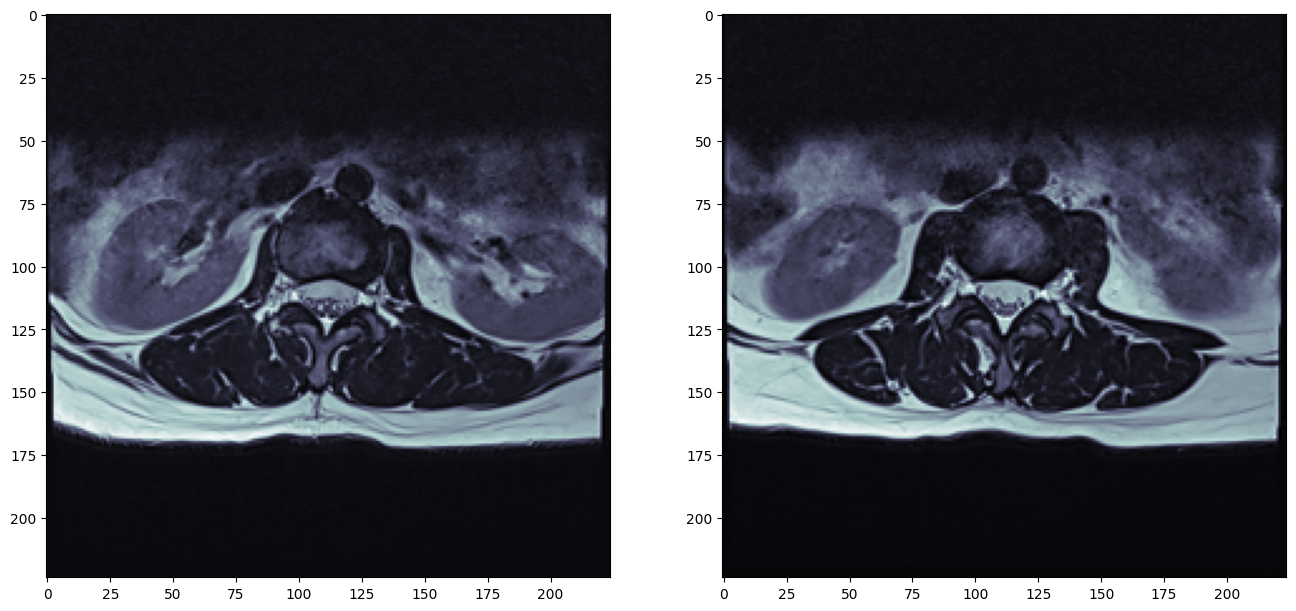

In [39]:
tmp_ds = RSNAUncroppedImageDataset(train_df)
tmp_dl = torch.utils.data.DataLoader(
  tmp_ds,
  batch_size=1,
  shuffle=False
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
for i, (img, label) in enumerate(tmp_dl):
    if i == 2: break
    y = img[0][0].numpy()
    ax[i].imshow(y, cmap=plt.cm.bone)
del tmp_ds, tmp_dl

# Training

## Load Model

In [40]:
referece_model_path = os.path.join(f"{REFERENCE_MODEL_DIR}/epoch_{REFERENCE_MODEL_BEST_EPOCH}/model_dict.pt")
model = load_model_severity_classification(state_dict=torch.load(referece_model_path))

In [41]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model: {count_trainable_parameters(model)}")

Number of trainable parameters in the model: 27584877


## Test forward

In [42]:
# Create dataset and dataloader
dataset = RSNAUncroppedImageDataset(train_df)
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=1,
  shuffle=True
)

In [43]:
# Get first input from dataloader
images, labels = next(iter(data_loader))

# Inference
model.to('cpu')
model.eval()
with torch.inference_mode():
    predictions = model(images)

In [44]:
print(f"Predicted values for 3 classes in one sample: {predictions.squeeze().tolist()}")

Predicted values for 3 classes in one sample: [0.11423039436340332, 0.19878798723220825, -0.4021736681461334]


## Train and validate

In [45]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
# !nvidia-smi

In [46]:
model_pipeline(config=CONFIG, model=model, model_dir=MODEL_DIR, train_df=train_df, val_df=val_df, device=device, 
               datasetter=RSNAUncroppedImageDataset, limit=None)

wandb: Tracking run with wandb version 0.18.6
wandb: Run data is saved locally in /home/jupyter/notebooks/wandb/run-20241113_022649-lswltotm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run warm-monkey-43
wandb: ⭐️ View project at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: 🚀 View run at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/lswltotm
  0%|          | 0/6 [00:00<?, ?it/s]

Loss after 00950 examples: 1.204
Batch 20 Metrics:
  Accuracy: 61.58%
  Class 0: Precision: 0.7301, Recall: 0.8292, F1-score: 0.7765
  Class 1: Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.1024, Recall: 0.1954, F1-score: 0.1344
Loss after 01950 examples: 1.093
Batch 40 Metrics:
  Accuracy: 69.10%
  Class 0: Precision: 0.6910, Recall: 1.0000, F1-score: 0.8173
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 02950 examples: 0.979
Batch 60 Metrics:
  Accuracy: 72.20%
  Class 0: Precision: 0.7255, Recall: 0.9972, F1-score: 0.8400
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.3333, Recall: 0.0333, F1-score: 0.0606
Loss after 03950 examples: 0.937
Batch 80 Metrics:
  Accuracy: 66.50%
  Class 0: Precision: 0.8008, Recall: 0.8453, F1-score: 0.8224
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.1892, Recall: 0

 17%|█▋        | 1/6 [07:29<37:28, 449.62s/it]

Validation Metrics:
  Loss: 0.7298
  Accuracy: 73.43%
  Class 0: Precision: 0.8473, Recall: 0.8993, F1-score: 0.8725
  Class 1: Precision: 0.4143, Recall: 0.1234, F1-score: 0.1902
  Class 2: Precision: 0.3898, Recall: 0.7419, F1-score: 0.5111
Loss after 07889 examples: 0.912
Batch 20 Metrics:
  Accuracy: 72.95%
  Class 0: Precision: 0.9002, Recall: 0.8432, F1-score: 0.8707
  Class 1: Precision: 0.3643, Recall: 0.2670, F1-score: 0.3082
  Class 2: Precision: 0.3529, Recall: 0.7595, F1-score: 0.4819
Loss after 08889 examples: 0.848
Batch 40 Metrics:
  Accuracy: 70.00%
  Class 0: Precision: 0.8865, Recall: 0.8129, F1-score: 0.8481
  Class 1: Precision: 0.3211, Recall: 0.3081, F1-score: 0.3144
  Class 2: Precision: 0.3861, Recall: 0.6703, F1-score: 0.4900
Loss after 09889 examples: 0.670
Batch 60 Metrics:
  Accuracy: 71.90%
  Class 0: Precision: 0.8878, Recall: 0.8558, F1-score: 0.8715
  Class 1: Precision: 0.2632, Recall: 0.1389, F1-score: 0.1818
  Class 2: Precision: 0.3667, Recall: 0.777

 33%|███▎      | 2/6 [11:39<22:07, 331.91s/it]

Validation Metrics:
  Loss: 0.6645
  Accuracy: 75.80%
  Class 0: Precision: 0.8894, Recall: 0.8657, F1-score: 0.8774
  Class 1: Precision: 0.4225, Recall: 0.4638, F1-score: 0.4422
  Class 2: Precision: 0.5645, Recall: 0.5645, F1-score: 0.5645
Loss after 14828 examples: 0.529
Batch 20 Metrics:
  Accuracy: 79.79%
  Class 0: Precision: 0.9282, Recall: 0.8484, F1-score: 0.8865
  Class 1: Precision: 0.5135, Recall: 0.6032, F1-score: 0.5547
  Class 2: Precision: 0.6139, Recall: 0.8267, F1-score: 0.7045
Loss after 15828 examples: 0.556
Batch 40 Metrics:
  Accuracy: 79.30%
  Class 0: Precision: 0.9264, Recall: 0.8666, F1-score: 0.8955
  Class 1: Precision: 0.4826, Recall: 0.5079, F1-score: 0.4949
  Class 2: Precision: 0.5940, Recall: 0.8144, F1-score: 0.6870
Loss after 16828 examples: 0.694
Batch 60 Metrics:
  Accuracy: 76.50%
  Class 0: Precision: 0.9123, Recall: 0.8375, F1-score: 0.8733
  Class 1: Precision: 0.4176, Recall: 0.4086, F1-score: 0.4130
  Class 2: Precision: 0.5478, Recall: 0.914

 50%|█████     | 3/6 [15:48<14:42, 294.07s/it]

Validation Metrics:
  Loss: 0.7050
  Accuracy: 76.45%
  Class 0: Precision: 0.9046, Recall: 0.8669, F1-score: 0.8853
  Class 1: Precision: 0.4265, Recall: 0.5064, F1-score: 0.4630
  Class 2: Precision: 0.5776, Recall: 0.5403, F1-score: 0.5583
Loss after 21767 examples: 0.420
Batch 20 Metrics:
  Accuracy: 86.21%
  Class 0: Precision: 0.9352, Recall: 0.9031, F1-score: 0.9189
  Class 1: Precision: 0.6571, Recall: 0.7005, F1-score: 0.6781
  Class 2: Precision: 0.8152, Recall: 0.9146, F1-score: 0.8621
Loss after 22767 examples: 0.313
Batch 40 Metrics:
  Accuracy: 88.20%
  Class 0: Precision: 0.9542, Recall: 0.9112, F1-score: 0.9322
  Class 1: Precision: 0.6562, Recall: 0.7200, F1-score: 0.6866
  Class 2: Precision: 0.8165, Recall: 0.9570, F1-score: 0.8812
Loss after 23767 examples: 0.148
Batch 60 Metrics:
  Accuracy: 88.20%
  Class 0: Precision: 0.9578, Recall: 0.9007, F1-score: 0.9284
  Class 1: Precision: 0.6757, Recall: 0.7732, F1-score: 0.7212
  Class 2: Precision: 0.8435, Recall: 0.960

 67%|██████▋   | 4/6 [19:57<09:13, 276.59s/it]

Validation Metrics:
  Loss: 0.8059
  Accuracy: 76.37%
  Class 0: Precision: 0.9171, Recall: 0.8449, F1-score: 0.8795
  Class 1: Precision: 0.4276, Recall: 0.5532, F1-score: 0.4824
  Class 2: Precision: 0.6016, Recall: 0.5968, F1-score: 0.5992
Loss after 28706 examples: 0.293
Batch 20 Metrics:
  Accuracy: 88.74%
  Class 0: Precision: 0.9606, Recall: 0.8982, F1-score: 0.9284
  Class 1: Precision: 0.6856, Recall: 0.8177, F1-score: 0.7458
  Class 2: Precision: 0.8851, Recall: 0.9625, F1-score: 0.9222
Loss after 29706 examples: 0.297
Batch 40 Metrics:
  Accuracy: 89.40%
  Class 0: Precision: 0.9649, Recall: 0.8901, F1-score: 0.9260
  Class 1: Precision: 0.6751, Recall: 0.8556, F1-score: 0.7547
  Class 2: Precision: 0.9444, Recall: 0.9903, F1-score: 0.9668
Loss after 30706 examples: 0.179
Batch 60 Metrics:
  Accuracy: 91.40%
  Class 0: Precision: 0.9655, Recall: 0.9268, F1-score: 0.9457
  Class 1: Precision: 0.7282, Recall: 0.8161, F1-score: 0.7696
  Class 2: Precision: 0.9182, Recall: 0.990

 83%|████████▎ | 5/6 [24:06<04:26, 266.40s/it]

Validation Metrics:
  Loss: 1.0605
  Accuracy: 77.11%
  Class 0: Precision: 0.9006, Recall: 0.8808, F1-score: 0.8906
  Class 1: Precision: 0.4392, Recall: 0.5532, F1-score: 0.4896
  Class 2: Precision: 0.6341, Recall: 0.4194, F1-score: 0.5049
Loss after 35645 examples: 0.135
Batch 20 Metrics:
  Accuracy: 92.74%
  Class 0: Precision: 0.9775, Recall: 0.9248, F1-score: 0.9504
  Class 1: Precision: 0.7350, Recall: 0.9018, F1-score: 0.8099
  Class 2: Precision: 0.9880, Recall: 1.0000, F1-score: 0.9939
Loss after 36645 examples: 0.276
Batch 40 Metrics:
  Accuracy: 91.80%
  Class 0: Precision: 0.9785, Recall: 0.9138, F1-score: 0.9450
  Class 1: Precision: 0.7541, Recall: 0.8932, F1-score: 0.8178
  Class 2: Precision: 0.9245, Recall: 1.0000, F1-score: 0.9608
Loss after 37645 examples: 0.384
Batch 60 Metrics:
  Accuracy: 91.20%
  Class 0: Precision: 0.9741, Recall: 0.9051, F1-score: 0.9383
  Class 1: Precision: 0.7131, Recall: 0.8942, F1-score: 0.7934
  Class 2: Precision: 0.9720, Recall: 0.990

100%|██████████| 6/6 [28:15<00:00, 282.53s/it]

Validation Metrics:
  Loss: 1.1706
  Accuracy: 74.73%
  Class 0: Precision: 0.9198, Recall: 0.8229, F1-score: 0.8687
  Class 1: Precision: 0.4091, Recall: 0.6128, F1-score: 0.4906
  Class 2: Precision: 0.6020, Recall: 0.4758, F1-score: 0.5315



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▁▃▃▂▂▃▂▄▃▃▃▃▄▅▅▅▄▅▄▅▇▇▇▇▇▇▇▇▇█▇▇▇▇██████
wandb:         epoch ▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
wandb:          loss █▇▇▆▅▅▄▆▆▅▅▄▃▄▄▄▅▅▅▄▃▂▁▂▃▂▂▂▂▁▁▂▂▂▁▂▃▂▁▁
wandb: test_accuracy ▁▆▇▇█▃
wandb:     test_loss ▂▁▂▃▆█
wandb: 
wandb: Run summary:
wandb:      accuracy 0.92214
wandb:         epoch 5
wandb:          loss 0.13137
wandb: test_accuracy 0.74734
wandb:     test_loss 1.17061
wandb: 
wandb: 🚀 View run warm-monkey-43 at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/lswltotm
wandb: ⭐️ View project at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20241113_022649-lswltotm/logs


<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by 2nd epoch (i.e. epoch 1) because it has the lowest validation loss and highest validation accuracy
</strong></div>